# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [30]:
# Do all imports and installs here
import pandas as pd
from pyspark.sql import SparkSession
import numpy as np
import re
from pyspark.sql.functions import udf, col
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import configparser
import os
%matplotlib inline

### Step 1: Scope the Project and Gather Data

#### Scope 
In this project, we will use the I94 immigration data and an additional visa types dataset to create visualisations that will allow us to see if there are differences in number of people that travel to the US for business or pleasure purposes. The visa types dataset includes the code of the visa (e.g. B1), the class (e.g. Temporary visitors for business) and a small description of the visa. 

Our hypothesis is that number of men in their 20s to their 50s (work life of a standard person) are travelling more to the US under a Visa that allows temporary visits for business purposes, which could be correlated to the gender gap that currently exists in most of the workplaces,since this could imply that more men are sent to the US for closing deals, working on international projects, among others.

We will present our visualisations that will result from the data transformation. We will use Spark for this task, since we are handling a great amount of data and also we could then save as a parquet files in S3, so we can get more insights from the data in the future.

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

The I94 immigration data comes from the US National Tourism and Trade Office. It is provided in SAS7BDAT format, some of the feautures are:

i94yr = 4 digit year
i94mon = numeric month
i94cit = 3 digit code of origin city
i94port = 3 character code of destination USA city
arrdate = arrival date in the USA
i94mode = 1 digit travel code
depdate = departure date from the USA
i94visa = reason for immigration




### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

In [2]:
# Read in the data here
df_airport = pd.read_csv('airport-codes_csv.csv')

In [3]:
df_airport[df_airport['type'] == 'large_airport'][:10]

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
11831,AYPY,large_airport,Port Moresby Jacksons International Airport,146.0,OC,PG,PG-NCD,Port Moresby,AYPY,POM,NaN,"147.22000122070312, -9.443380355834961"
12297,BIKF,large_airport,Keflavik International Airport,171.0,EU,IS,IS-2,ReykjavÃ­k,BIKF,KEF,NaN,"-22.605600357056, 63.985000610352"
12344,BKPR,large_airport,PriÅ¡tina International Airport,1789.0,EU,XK,XK-01,Prishtina,BKPR,PRN,NaN,"21.035801, 42.5728"
12782,BS-0007,large_airport,Osman Ibrahim,NaN,NaN,BS,BS-EX,All,NaN,NaN,NaN,"0, 0"
13613,CA-0671,large_airport,Cyll,NaN,NaN,CA,CA-U-A,NaN,NaN,NaN,NaN,"-110.072021, 53.310365"
15065,CMN,large_airport,CMN,NaN,AF,MA,MA-CAS,NaN,NaN,CMN,NaN,"0, 0"
15161,CN-0083,large_airport,Guodu air base,NaN,AS,CN,CN-U-A,NaN,NaN,NaN,NaN,"117.63201, 36.001741"
16289,CYEG,large_airport,Edmonton International Airport,2373.0,NaN,CA,CA-AB,Edmonton,CYEG,YEG,CYEG,"-113.580001831, 53.309700012200004"
16344,CYHZ,large_airport,Halifax / Stanfield International Airport,477.0,NaN,CA,CA-NS,Halifax,CYHZ,YHZ,NaN,"-63.5085983276, 44.8807983398"
16419,CYOW,large_airport,Ottawa Macdonald-Cartier International Airport,374.0,NaN,CA,CA-ON,Ottawa,CYOW,YOW,YOW,"-75.66919708251953, 45.3224983215332"


In [5]:
df_us_cities = pd.read_csv('us-cities-demographics.csv', sep=';')

In [6]:
df_us_cities.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [8]:
df_immigration_sample = pd.read_csv('immigration_data_sample.csv')

In [9]:
df_immigration_sample.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [13]:
df_i94mode = pd.read_csv('i94mode.csv')

In [14]:
df_i94mode.head()

,code,transportation
0,1,Air
1,2,Sea
2,3,Land
3,9,Not reported


In [15]:
df_i94addr = pd.read_csv('i94addr.csv')

In [16]:
df_i94addr.head()

,code,state
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


In [17]:
df_i94port = pd.read_csv('i94port.csv')

In [18]:
df_i94port.head()

,code,port,city,state_country
0,ALC,"ALCAN, AK",ALCAN,AK
1,ANC,"ANCHORAGE, AK",ANCHORAGE,AK
2,BAR,"BAKER AAF - BAKER ISLAND, AK",BAKER AAF - BAKER ISLAND,AK
3,DAC,"DALTONS CACHE, AK",DALTONS CACHE,AK
4,PIZ,"DEW STATION PT LAY DEW, AK",DEW STATION PT LAY DEW,AK


In [19]:
df_i94visa = pd.read_csv('i94visa.csv')

In [20]:
df_i94visa.head()

,code,travel_purpose
0,1,Business
1,2,Pleasure
2,3,Student


In [142]:
df_airlines_codes = pd.read_csv('airlines_IATA_codes.csv').dropna()

In [143]:
df_airlines_codes.head(10)

,iata,name
0,-,Private flight
1,1T,1Time Airline
2,Q5,40-Mile Air
3,AN,Ansett Australia
4,1B,Abacus International
5,ZI,Aigle Azur
6,AQ,Aloha Airlines
7,AA,American Airlines
8,OZ,Asiana Airlines
9,4K,Askari Aviation


In [144]:
df_airlines_codes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009 entries, 0 to 1009
Data columns (total 2 columns):
iata    1009 non-null object
name    1009 non-null object
dtypes: object(2)
memory usage: 23.6+ KB


In [23]:
df_i94cit_i94res = pd.read_csv('i94cit_i94res.csv')

In [24]:
df_i94cit_i94res.head()

,code,country
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [25]:
df_visatypes = pd.read_csv('visa_types.csv')

In [26]:
df_visatypes.head()

,code,description,class
0,CW1,CNMI-only transitional workers,Temporary workers and their families
1,CW2,Spouses and children of CW1,Temporary workers and their families
2,H1B,Temporary workers in specialty occupations,Temporary workers and their families
3,H1B1,Chile and Singapore Free Trade Agreement aliens,Temporary workers and their families
4,H1C,Registered nurses participating in the Nursing...,Temporary workers and their families


In [27]:
## Visa types aggregated by female , male

In [30]:
type(df_immigration_sample['biryear'].iloc[1])

numpy.float64

In [ ]:
#Distribution of Temporary visitors for business

In [258]:
df_business = df_query1e[df_query1e['class'] == 'Temporary visitors for business'][['gender','group_ages','count']]
df_business.reset_index(inplace=True)  

In [262]:
df_business = df_business[['gender','group_ages','count']]

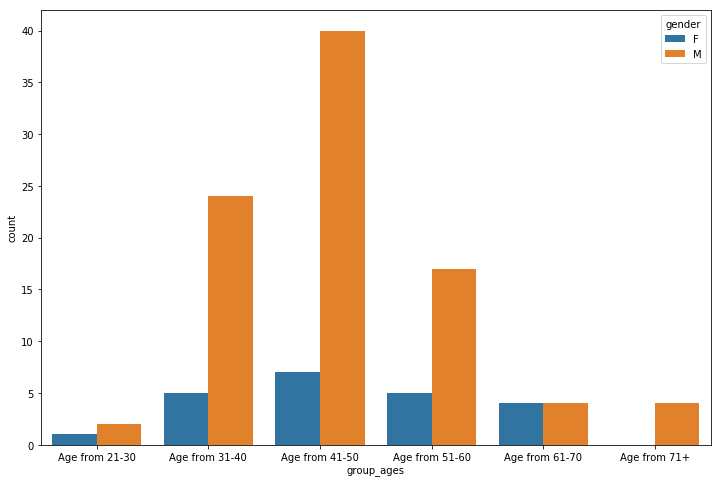

In [266]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x="group_ages", y="count", hue="gender", data=df_business)

In [ ]:
#Distribution of Temporary visitors for pleasure

In [267]:
df_pleasure = df_query1e[df_query1e['class'] == 'Temporary visitors for pleasure'][['gender','group_ages','count']]
df_pleasure.reset_index(inplace=True) 
df_pleasure = df_pleasure[['gender','group_ages','count']]

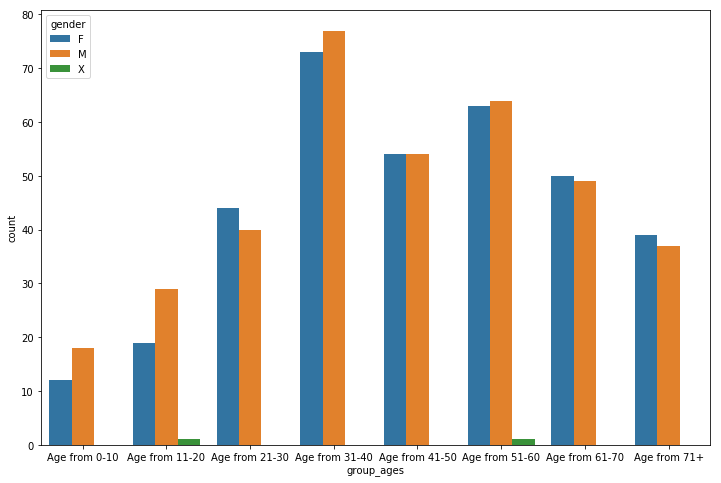

In [268]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x="group_ages", y="count", hue="gender", data=df_pleasure)

In [ ]:
#QUERY 3:Airlines preferred by females, males

In [93]:
def clean_airline(airline):
    if type(airline) == str:
        return re.sub('[^A-Za-z0-9]+', '', airline)
    else:
        return 'Unknown'

In [92]:
type(df_joined['airline'].iloc[2])

str

In [94]:
df_joined['clean_airline'] = df_joined.apply(lambda s: clean_airline(s['airline']), axis=1)

In [149]:
df_joined_airlines = pd.merge(df_joined,df_airlines_codes, how='left', left_on=['clean_airline'], right_on=['iata'])

In [210]:
df_male_airlines = df_male_airlines.rename(columns={'name': 'Airline'})

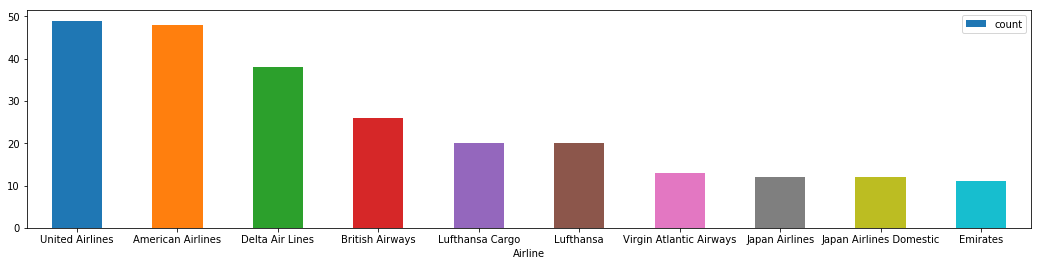

In [211]:
ax1 = df_male_airlines.plot.bar(x='Airline', y='count', rot=0, figsize=(18,4))
plt.show()

In [190]:
df_female_airlines = df_query3[df_query3['gender'] == 'F'][['name', 'count']][:10]

In [191]:
df_female_airlines.head()

,name,count
2,American Airlines,43
4,United Airlines,30
5,Delta Air Lines,30
9,Virgin Atlantic Airways,18
10,British Airways,16


In [205]:
df_female_airlines = df_female_airlines.rename(columns={'name': 'Airline'})

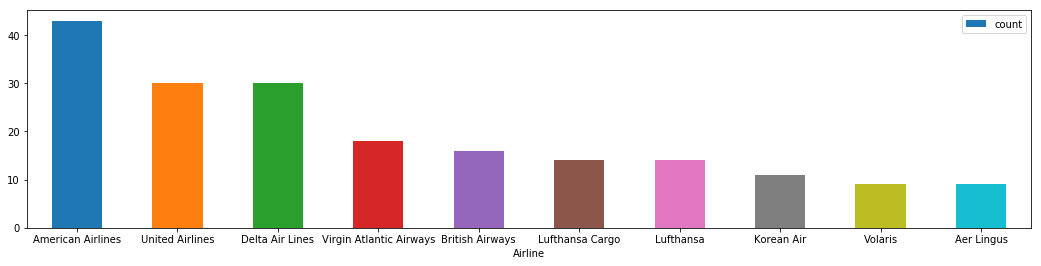

In [212]:
ax = df_female_airlines.plot.bar(x='Airline', y='count', rot=0, figsize=(18,4))
plt.show()

In [28]:
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
df_test1 = pd.read_sas(fname, 'sas7bdat', encoding="ISO-8859-1")

In [11]:
#write to parquet
df_spark.write.parquet("sas_data")
df_spark=spark.read.parquet("sas_data")


#### Cleaning Steps
Document steps necessary to clean the data

In [63]:
# Performing cleaning tasks here

#The cleaning and transformation is defined in the ETL


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

I chose this star scheme since there are more tables that can be treated as dimensional tables. In addition, I didn't use many fields of the original raw data since there were not relevant for the purpose of the scope defined above.

<p align="center">
<img src=diagram.png>
</p>


#### 3.2 Mapping Out Data Pipelines

1-. Create a spark session
2-. Read the SAS files as well as the additional tables such as visa_types.csv
3-. Join the tables and select only the fields that are relevant for the scope of this project.
4-. Save the tables as a parquet file in the sas_data folder.
5-. Create an aggregated data frame in order to use for our visualizations.

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [15]:
def create_spark_session():
    """
    Create a Spark Session.
    Output: Spark Session
    """
    spark = SparkSession \
        .builder \
        .config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.10") \
        .enableHiveSupport().getOrCreate()
    return spark

In [43]:
def group_ages(age):
    """
    Convert the age into a group of ages.
    Params: age
    """
    if age is not 'Unknown':
        if 0 <= age <= 10:
            return 'Age from 0-10'
        elif 11 <= age <= 20:
            return 'Age from 11-20'
        elif 21 <= age <= 30:
            return 'Age from 21-30'
        elif 31 <= age <= 40:
            return 'Age from 31-40'
        elif 41 <= age <= 50:
            return 'Age from 41-50'
        elif 51 <= age <= 60:
            return 'Age from 51-60'
        elif 61 <= age <= 70:
            return 'Age from 61-70'
        elif age >= 71:
            return 'Age from 71+'
    else:
        return 'Unknown'


def get_age(year):
    """
    Compute an estimate of the age.
    Params: year
    """
    if type(year) == float:
        age = 2019 - year
        return age
    else:
        return 'Unknown'

In [55]:
def process_immigration_file(spark, input_data, visa_type_file, output_path):
    """
    Process the file to get a join for further
    :param spark: spark session
    :param input_data: parquet filepath
    :param visa_type_file: directory of the visa type file
    :param output_path: where to save
    """

    # Load immigration dataset
    df_immigration = spark.read.format('com.github.saurfang.sas.spark').load(input_data)
    print('Immigration data loaded successfully')

    # Load visa types dataset
    df_visatypes = spark.read.format("csv").option("header", "true").load(visa_type_file)
    print('Visa types dataset loaded successfully')
    print(df_visatypes.head())
    print(df_immigration.head())

    # Join
    join_conditions = [df_immigration.visatype == df_visatypes.code]
    df_joined = df_immigration.join(df_visatypes, join_conditions, 'left')
    print('Immigration and visa types dataframes joined')

    # Compute age
    compute_age = udf(lambda x: get_age(x), FloatType())
    df_joined = df_joined.withColumn("approx_age", compute_age(col("biryear")))
    print('column approx_age was added')

    # Compute age groups
    compute_group_age = udf(lambda x: group_ages(x), FloatType())
    df_joined = df_joined.withColumn("group_ages", compute_group_age(col("approx_age")))
    print('column group_age was added')

    # Extract the fields
    immigration_table = df_joined\
        .withColumn('immigration_id', monotonically_increasing_id())\
        .select(['immigration_id',
                 'i94yr',
                 'i94mon',
                 'i94cit',
                 'i94res',
                 'i94port',
                 'arrdate',
                 'i94mode',
                 'i94addr',
                 'depdate',
                 'i94bir',
                 'i94visa',
                 'count',
                 'biryear',
                 'gender',
                 'insnum',
                 'airline',
                 'fltno',
                 'visatype',
                 'code',
                 'description',
                 'class',
                 'approx_age',
                 'group_ages'])

    # Write immigration table as a parquet file partitioned by
    immigration_file = f'{output_path}/immigration/'
    cols_immigration_partition = ['gender', 'class']
    immigration_table.write.parquet(immigration_file, mode='overwrite')
    print("Immigration table wrote to parquet")

In [73]:
def create_aggregation_visas(filename):
    """
    Create an aggregated dataframe grouped by class, gender and group ages.
    :param df_joined: Immigration and visa types dataframes joined.
    :return: df_query: Aggregated dataframe by the gender, group ages and visa class.
    """
    
    #Read the data
    df_joined=spark.read.parquet(filename)
    
    # Create count aggregation based on the type of Visa, gender and group ages.
    df_query = df_joined.groupBy('class', 'gender', 'group_ages').agg({'count':'count'})
    df_query_new = df_query.toPandas()

    return df_query_new

In [77]:
def query_visa(df_query, class_label):
    """
    Filter an aggregated dataframe, transform it to plot it.
    :param df_query:
    :param class_label: could be Temporary visitors for pleasure or
    Temporary visitors for business
    :return:
    """

    # Create a view of the type of visa
    df_query_new = df_query[df_query['class'] == class_label][['gender', 'group_ages', 'count']]
    df_query_new.reset_index(inplace=True)
    df_query_new= df_query_new[['gender', 'group_ages', 'count']]
    print(f'Create a query aggregated data frame: {class_label}')

    # Plot the graph for the business data frame
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="group_ages", y="Counts", hue="gender", data=df_query_new)
    plt.show()

In [58]:
def main():
    """
    Create a spark session, process the song and log datasets, transforms the datasets
    and save the users, artists, songs, time and songplays tables.
    """
    spark = create_spark_session()
    output_path = "sas_data"
    input_data = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
    visa_type_path = "visa_types.csv"

    df_joined = process_immigration_file(spark, input_data, visa_type_path, output_path)
    df_query = create_aggregation_visas(df_joined)

    query_visa(df_query, 'Temporary visitors for pleasure')

    query_visa(df_query, 'Temporary visitors for business')

In [60]:
spark = create_spark_session()
output_path = "sas_data"
input_data = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
visa_type_path = "visa_types.csv"

In [61]:
df_joined = process_immigration_file(spark, input_data, visa_type_path, output_path)

Immigration data loaded successfully
Visa types dataset loaded successfully
Row(code='CW1', description='CNMI-only transitional workers', class='Temporary workers and their families')
Row(cicid=6.0, i94yr=2016.0, i94mon=4.0, i94cit=692.0, i94res=692.0, i94port='XXX', arrdate=20573.0, i94mode=None, i94addr=None, depdate=None, i94bir=37.0, i94visa=2.0, count=1.0, dtadfile=None, visapost=None, occup=None, entdepa='T', entdepd=None, entdepu='U', matflag=None, biryear=1979.0, dtaddto='10282016', gender=None, insnum=None, airline=None, admnum=1897628485.0, fltno=None, visatype='B2')
Immigration and visa types dataframes joined
column approx_age was added
column group_age was added
Immigration table wrote to parquet


In [75]:
df_query = create_aggregation_visas("sas_data/immigration/")

In [ ]:
query_visa(df_query, 'Temporary visitors for pleasure')

In [ ]:
query_visa(df_query, 'Temporary visitors for business')

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
def quality_test(df, description):
    '''
    Input: Spark dataframe
    Output: Print outcome of data quality check
    '''

    result = df.count()
    if result == 0:
        print("Data quality test failed for {} with zero records".format(description))
    else:
        print("Data quality check passed for {} with {} records".format(description, result))
    return 0

In [ ]:
quality_tests(df_immigration, "immigration table")

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

We chose Spark since it can handle easily large amounts of data; in addition we don't need to create dimensional, fact or staging tables; instead the schema-on-read capability allows us work on the data without putting hard constraints on our schema. Regarding the libraries, we use pyspark.sql to process the files and manipulate them to create new tables and visualizations. Furthermore, we used seaborn and matplolib to plot two queries related to the visa type and the gender.

* Propose how often the data should be updated and why.

The goal was to understand the differences between men and women regarding the visa types and the type of visa. Our results suggest that there's a great difference when it comes the visa for business purposes, which could imply that more men are used to travel to the US for business purposes than women, or that more men are in an executive position that includes the responsability of travelling to close a deal for example. This pattern will not change in months or even in a year, so it makes sense to keep a record of the changes and update the data every year or every 2 years.

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 If the data was increased by 100x, we would no longer process the data as a single batch job, we might need to move to a spark cluster.
 
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 We could use airflow and use the scheduling to update the data on a daily basis.
 
 * The database needed to be accessed by 100+ people.
One potential solution could be storing the dataset on Redshift; do the heavy lifting in Spark and when the data is clean and transformed we can move it to Redshift.
 